In [3]:
import tellurium as te
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 

['time',
 'V_tot_fl',
 '[c_e]',
 '[c_i]',
 'R',
 'r',
 'r_os',
 'r_b',
 'pi_t',
 'V_ref']

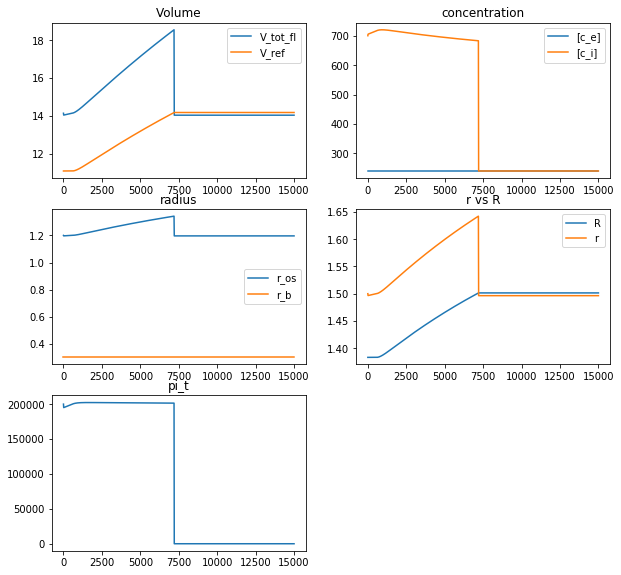

In [140]:
model=te.loadAntimonyModel('volume_reference_radius.txt')
sim=model.simulate(1,15000,1000, selections = ['time','V_tot_fl', '[c_e]', '[c_i]', 'R', 'r','r_os', 'r_b', 'pi_t', 'V_ref'])

fig1=plt.figure(1, figsize=(10,20))

variables = sim.colnames
number_of_variables = len(variables)
k=0

for var in variables:
    
    if var == 'time':
        continue
    if var.startswith('V'):
        plt.subplot(number_of_variables/2 + 1,2, 1)
        plt.plot(sim['time'],sim[var], label =var)
        plt.title('Volume')
        plt.legend()
        #plt.ylim(0,100)
    elif var.startswith('[c'):
        plt.subplot(number_of_variables/2 + 1,2, 2)
        plt.plot(sim['time'],sim[var], label = var)
        plt.title('concentration')
        plt.legend()
        #plt.ylim(0,100)
    elif var.startswith('r_'):
        plt.subplot(number_of_variables/2 + 1,2, 3)
        plt.plot(sim['time'],sim[var], label = var)
        plt.title('radius')
        plt.legend()
        #plt.ylim(0,100) 
    elif var in ['r', 'R']:
        plt.subplot(number_of_variables/2 + 1,2, 4)
        plt.plot(sim['time'],sim[var], label = var)
        plt.title('r vs R')
        plt.legend()
        #plt.ylim(0,100)    
    else:    
        k+=1
        plt.subplot(number_of_variables/2 + 1,2, 4+k)    
        plt.plot(sim['time'],sim[var], label =var)
        plt.title(var)    
variables


In [40]:
var.startswith('pi')


True

In [94]:
sim


       time, V_tot_fl, [c_e],   [c_i],    R,       r,        pi_t,   V_ref
 [[       1,  61.6009,   240,     440, 1.74,    2.45,      100000, 22.0666],
  [  16.014,   61.961,   240, 441.575, 1.74, 2.45476,      102624, 22.0666],
  [  31.028,  62.1549,   240, 444.325, 1.74, 2.45732,      104026, 22.0666],
  [  46.042,   62.349,   240, 447.065, 1.74, 2.45988,      105423, 22.0666],
  [ 61.0561,  62.5435,   240, 449.794, 1.74, 2.46243,      106814, 22.0666],
  [ 76.0701,  62.7382,   240, 452.512, 1.74, 2.46499,      108200, 22.0666],
  [ 91.0841,  62.9331,   240, 455.219, 1.74, 2.46754,      109580, 22.0666],
  [ 106.098,  63.1283,   240, 457.916, 1.74, 2.47008,      110955, 22.0666],
  [ 121.112,  63.3238,   240, 460.602, 1.74, 2.47263,      112325, 22.0666],
  [ 136.126,  63.5195,   240, 463.277, 1.74, 2.47518,      113689, 22.0666],
  [  151.14,  63.7155,   240, 465.943, 1.74, 2.47772,      115048, 22.0666],
  [ 166.154,  63.9117,   240, 468.598, 1.74, 2.48026,      116402, 22.0666],
 